In [15]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv

In [36]:
df = pd.read_csv('./Data/Highway_V1.csv', nrows=100)
print(df.head())
print(df.shape)
N = df.shape[0]

def write_csv(data_row):
    path  = "kernelABC_NO_vehsPerHour.csv"
    with open(path,'a+') as f:
        csv_write = csv.writer(f)
        csv_write.writerow(data_row)

write_csv(["maxSpeed","minGap","accel","decel", "θ distance", "Ɣ**2", "ƛ", "Σw"])

    maxSpeed    minGap     accel     decel       y_flow    y_speed   distance
0  25.000000  2.500000  2.600000  4.500000  1853.935338  12.747027   0.000000
1  21.474007  1.338518  4.533689  5.519486  1783.772727  21.129545  70.661578
2  15.154605  4.173119  7.197450  0.605079  1778.685455  14.513182  75.270607
3  24.810924  7.453838  9.010386  2.086053  1790.871818  24.017045  64.062632
4  40.728587  0.635601  6.904782  6.675052  1810.636364  38.569545  50.414320
(100, 7)


In [37]:
# **********
# Read CSV data
# **********

# Get measurement: Y
y_flow = np.array(df.loc[:,'y_flow']).reshape(N,1)
y_speed = np.array(df.loc[:,'y_speed']).reshape(N,1)
y = np.concatenate((y_flow, y_speed), axis=1)

y_star = y[0]
y_sensor = y[1:]
print("y_star: ", y_star)
print("y_sensor[0]: ", y_sensor[0])
print("y_sensor shpe: ", y_sensor.shape)


# Get param: Theta
maxSpeed = np.array(df.loc[:,'maxSpeed']).reshape(N,1)
minGap = np.array(df.loc[:,'minGap']).reshape(N,1)
accel = np.array(df.loc[:,'accel']).reshape(N,1)
decel = np.array(df.loc[:,'decel']).reshape(N,1)
theta = np.concatenate((maxSpeed, minGap, accel, decel), axis=1)
# theta = np.concatenate((minGap, accel, decel), axis=1)


theta_star = theta[0]
theta_sensor = theta[1:]

print("")
print("theta_star: ", theta_star)
print("theta_sensor[0]: ", theta_sensor[0])
print("theta_sensor shape: ", theta_sensor.shape)

write_csv(theta_star)

y_star:  [1853.93533784   12.74702703]
y_sensor[0]:  [1783.77272727   21.12954545]
y_sensor shpe:  (99, 2)

theta_star:  [25.   2.5  2.6  4.5]
theta_sensor[0]:  [21.47400713  1.338518    4.53368855  5.51948633]
theta_sensor shape:  (99, 4)


In [38]:
'''
****************
Kernel ABC Class
****************

input: 
    - lambda: float
    - theta : 2D array of parameters
    - y     : 2D array of measures   (sensor data)
    - y_star: 1D array of measures   (ground truth)
    
output:
    - theta_hat: 1D array of parameters (predicted)
    - w        : calculated weight vector
'''

class kernel_ABC:
    def __init__(self, lambda_, gamma, theta, y, y_star):
        self.lambda_ = lambda_
        self.theta = theta
        self.y = y
        self.y_star = y_star
        
        self.N = len(y)
        self.GaMa = gamma
        self.G = self.calc_G()
        self.I = np.identity(self.N)
        self.k_vec = self.calc_k_vector()
    
    def get_N(self):
        return self.N
    
    def calc_k(self, yi, yj):
        __yi = yi.reshape(yi.shape[0],1)
        __yj = yj.reshape(yj.shape[0],1)
        norm_distance = np.linalg.norm(yi - yj) ** 2
        gramm_value = (yi-yj).T @ (yi-yj)
        __temp = (__yi - __yj).T @ (__yi - __yj)
        
        # checked with in multiple way of computation
        assert abs(norm_distance - __temp[0][0]) < 1, f'{norm_distance} {__temp}'
        assert abs(gramm_value - __temp[0][0]) < 1, f'{gramm_matrix} {__temp}'
        assert abs(norm_distance - gramm_value) < 1
        
        k = np.exp( - 1 * norm_distance / self.GaMa )
#         assert k > 0.0, f'k is non-positive value {k}, norm_distance {norm_distance}, GaMa {self.GaMa}'
        return k
        
    def calc_Gama(self):
        # check that input of Gamma computation is from y_simulator 
        GaMa_mat = []
        for i in range(self.N):
            GaMa_row = []
            for j in range(self.N):
                if j != i:
                    GaMa_row.append( (self.y[i] - self.y[j]).T @ (self.y[i] - self.y[j]) )
            GaMa_mat.append(GaMa_row)
        GaMa_mat = np.array(GaMa_mat)
        __Gama_original = np.median(GaMa_mat)
        
        # double check
        distance_matrix = []
        for i in range(self.N):
            one_row = []
            for j in range(self.N):
                if j != i:
                    __dis = np.linalg.norm(self.y[i] - self.y[j]) ** 2
                    one_row.append(__dis)
            else:
                distance_matrix.append(one_row)
        
        # end for loop
        Gama = np.median(distance_matrix)
        
        assert abs(Gama - __Gama_original) < 1
        print("Original Gama: ", __Gama_original)
        return __Gama_original

        Y_Ystar_norm2 = df.loc[:,'distance']**2
        median_Y_Ystar_norm2 = np.median(Y_Ystar_norm2)
        print("The median of the norm^2 distance: ", median_Y_Ystar_norm2)
#         return median_Y_Ystar_norm2
        
        Y_Ystar_norm2 = df.loc[:,'distance']**2
        mean_Y_Ystar_norm2 = np.mean(Y_Ystar_norm2)
        print("The mean of the norm^2 distance: ", mean_Y_Ystar_norm2)

#         return mean_Y_Ystar_norm2

    def calc_G(self):
        G = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(self.N):
                G[i][j] = self.calc_k(self.y[i], self.y[j])
        return G
    
    def calc_k_vector(self):
        k_vec = []  # (99,1)
        for i in range(self.N):
            # checked input of k is from y_simulator and y_star
            out_kernel = self.calc_k( self.y[i], self.y_star )
            assert isinstance(out_kernel, float)
            k_vec.append( out_kernel )
        # k_vec = np.array(k_vec).reshape(-1,1) # list to array
#         print("k_vec shape: ", k_vec.shape)   # size - 99x1
        return k_vec
    
    def calc_w(self):
        assert self.G.shape == (self.N, self.N)
        assert self.I.shape == (self.N, self.N) 
        mat_before_inverse = self.G + self.N * self.lambda_ * self.I
        assert mat_before_inverse.shape == (self.N, self.N)
        w = np.linalg.inv(mat_before_inverse) @ self.k_vec
#         print("w shape: ", w.shape) # size - 99x1
        assert len(w) == self.N
        print("weight sum: ", np.sum(w))
        return w
    
    def calc_theta_hat(self):
        self.w = self.calc_w()
        
        # double check to compute w
        check_params = []
        for one_param in self.theta.T:
            assert len(one_param) == self.N
            theta_hat_param = sum([self.w[index] * theta_value for index, theta_value in enumerate(one_param)])
            check_params.append(theta_hat_param)
        
        theta_hat = self.w.T @ self.theta
        return theta_hat

## Testing the Class ##
lambda_param = 0.01
gamma = 100000
kernelABC = kernel_ABC(lambda_ = lambda_param, gamma = gamma, theta = theta_sensor, y = y_sensor, y_star = y_star)
print("********************")
my_theta_hat = kernelABC.calc_theta_hat()
print("theta_hat: ", my_theta_hat)
print("theta_star:", theta_star)


# Only uncomment if you want to summarize EVERYTHING into a single value
# WARNING: this gives close to no insight on the actual performance of your model!
theta_distance = np.linalg.norm(theta_star - my_theta_hat)
# print("theta distance: ", theta_distance)

## Print to CSV ##
result_row = [my_theta_hat[0], my_theta_hat[1], my_theta_hat[2], my_theta_hat[3], theta_distance, kernelABC.GaMa, lambda_param, np.sum(kernelABC.w)]
write_csv(result_row)

********************
weight sum:  0.9198249826631426
theta_hat:  [31.59340745  4.18187583  4.95435264  5.56438402]
theta_star: [25.   2.5  2.6  4.5]


In [39]:
# print(kernelABC.k_vec[:3])
# print(kernelABC.get_N())


## Checking if my calc_k() is correct
print("")
print("y_star: ", y_star)
print("y_sensor[0]: ", y_sensor[0])
print("y_sensor[0]-y_star: ", y_sensor[0]-y_star)
print("||y_sensor[0]-y_star||^2: ", (y_sensor[0]-y_star).T@(y_sensor[0]-y_star))
print("k(y1,y*): ", np.exp( -855.9877918589245 / 44.885087477174366))


y_star:  [1853.93533784   12.74702703]
y_sensor[0]:  [1783.77272727   21.12954545]
y_sensor[0]-y_star:  [-70.16261057   8.38251843]
||y_sensor[0]-y_star||^2:  4993.058536499013
k(y1,y*):  5.220618458058683e-09


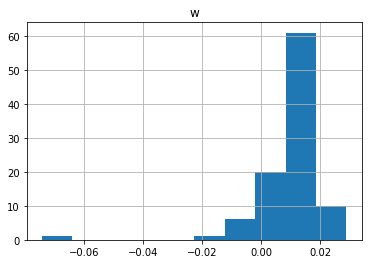

In [40]:
pd.DataFrame({'w': kernelABC.w}).hist(bins=10)
plt.show()

maxSpeed ground-truth:25.0 mean:25.81613028413045 median:25.756666374076428 var:10.559712164672703


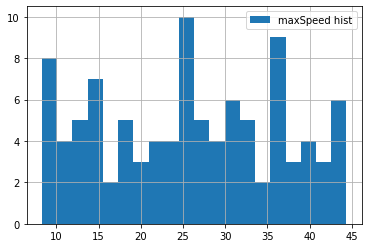

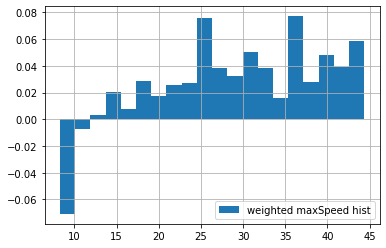

In [41]:
from statistics import mean, median, stdev
target_col = 'maxSpeed'
print(f'{target_col} ground-truth:{theta_star[0]} mean:{mean(df[target_col][1:])} median:{median(df[target_col][1:])} var:{stdev(df[target_col][1:])}')
df[target_col][1:].hist(bins=20, label='maxSpeed hist')
plt.legend()
plt.show()
df[target_col][1:].hist(bins=20, weights=kernelABC.w, label='weighted maxSpeed hist', density=True)
plt.legend()
plt.show()

minGap ground-truth:2.5 mean:4.604437605191697 median:4.387664100240587 var:2.669915887875759


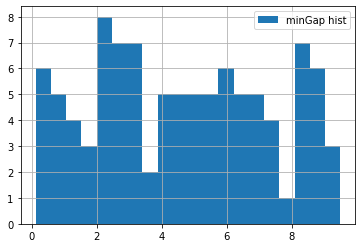

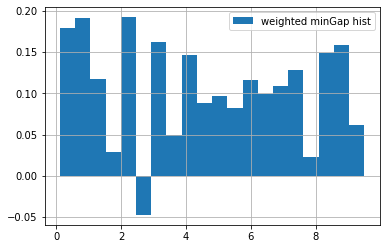

In [42]:
from statistics import mean, median, stdev
target_col = 'minGap'
print(f'{target_col} ground-truth:{theta_star[1]} mean:{mean(df[target_col][1:])} median:{median(df[target_col][1:])} var:{stdev(df[target_col][1:])}')
df[target_col][1:].hist(bins=20, label='minGap hist')
plt.legend()
plt.show()
df[target_col][1:].hist(bins=20, weights=kernelABC.w, label='weighted minGap hist', density=True)
plt.legend()
plt.show()

accel ground-truth:2.6 mean:5.553294619266452 median:5.972843740591108 var:2.877422946654236


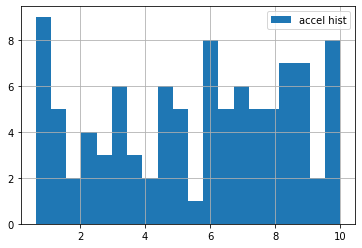

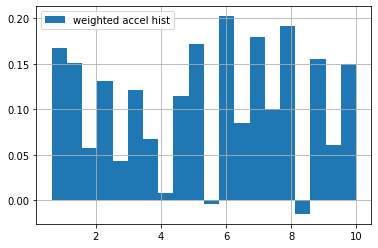

In [43]:
from statistics import mean, median, stdev
target_col = 'accel'
print(f'{target_col} ground-truth:{theta_star[2]} mean:{mean(df[target_col][1:])} median:{median(df[target_col][1:])} var:{stdev(df[target_col][1:])}')
df[target_col][1:].hist(bins=20, label='accel hist')
plt.legend()
plt.show()
df[target_col][1:].hist(bins=20, weights=kernelABC.w, label='weighted accel hist', density=True)
plt.legend()
plt.show()

decel ground-truth:4.5 mean:5.383695930559806 median:6.112998896391888 var:2.6484182444738744


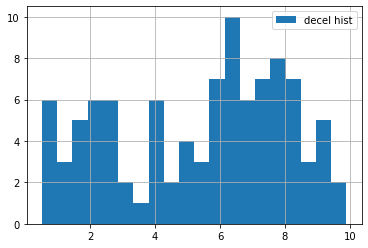

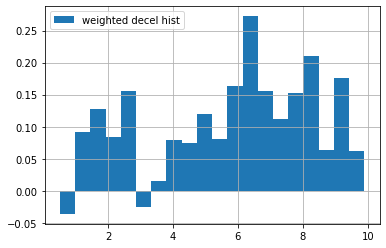

In [44]:
from statistics import mean, median, stdev
target_col = 'decel'
print(f'{target_col} ground-truth:{theta_star[3]} mean:{mean(df[target_col][1:])} median:{median(df[target_col][1:])} var:{stdev(df[target_col][1:])}')
df[target_col][1:].hist(bins=20, label='decel hist')
plt.legend()
plt.show()
df[target_col][1:].hist(bins=20, weights=kernelABC.w, label='weighted decel hist', density=True)
plt.legend()
plt.show()

In [45]:
mean_Y_Ystar_distance = df.loc[:,'distance']**2
print("The median of the norm^2 distance: ", np.median(mean_Y_Ystar_distance))

The median of the norm^2 distance:  4404.306059600427
